In [426]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import itertools



import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import seaborn as sns
sns.set_theme(style="white")
%matplotlib inline


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima_model import ARIMA
sm.tsa.statespace.SARIMAX
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
import pmdarima as pm
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
weekly = pd.read_csv('co2_weekly_mlo.csv')

In [3]:
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2441 entries, 0 to 2440
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 2441 non-null   int64  
 1   month                2441 non-null   int64  
 2   day                  2441 non-null   int64  
 3   decimal              2441 non-null   float64
 4   average              2441 non-null   float64
 5   ndays                2441 non-null   int64  
 6   1 year ago           2441 non-null   float64
 7   10 years ago         2441 non-null   float64
 8   increase since 1800  2441 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 171.8 KB


In [4]:
weekly.isna().sum()

year                   0
month                  0
day                    0
decimal                0
average                0
ndays                  0
1 year ago             0
10 years ago           0
increase since 1800    0
dtype: int64

In [5]:
#Make inital changes to data including: 
weekly['Date'] = pd.to_datetime(weekly[['year', 'month', 'day']])  #Creating a data column
weekly['average'] = weekly['average'].abs()  #Making all numbers in average column positive by changing them to absolute values
weekly['increase since 1800'] = weekly['increase since 1800'].abs()  #Making all numbers in increase since 1800 column positive by changing them to absolute values
weekly.drop(columns = ['decimal', '1 year ago', '10 years ago'], inplace = True) #Dropping unneeded columns 

In [6]:
inc1975=weekly.loc[[71, 73], 'increase since 1800'].mean() 
weekly.loc[[72, 81, 82, 83, 84], 'increase since 1800'] = inc1975 

inc1976=weekly.loc[[109,111], 'increase since 1800'].mean() 
weekly.loc[[110], 'increase since 1800'] = inc1976 

inc1982=weekly.loc[[411, 414], 'increase since 1800'].mean() 
weekly.loc[[409, 412, 413], 'increase since 1800'] = inc1982 

inc1983=weekly.loc[[480, 482], 'increase since 1800'].mean() 
weekly.loc[[481], 'increase since 1800'] = inc1983

inc1984=weekly.loc[[514, 519], 'increase since 1800'].mean() 
weekly.loc[[515, 516, 517, 518], 'increase since 1800'] = inc1984

inc2005=weekly.loc[[1638, 1640], 'increase since 1800'].mean() 
weekly.loc[[1639], 'increase since 1800'] = inc2005 

inc2008=weekly.loc[[1779, 1783], 'increase since 1800'].mean() 
weekly.loc[[1780, 1781, 1782], 'increase since 1800'] = inc2008

In [7]:
#Replace the values with the average for the rows above and below the value(s) that need to changed for the average column
ppm1975=weekly.loc[[71, 85], 'average'].mean() 
weekly.loc[[72, 81, 82, 83, 84], 'average'] = ppm1975  

ppm1976=weekly.loc[[109, 111], 'average'].mean() 
weekly.loc[[110], 'average'] = ppm1976  

ppm1982=weekly.loc[[408, 414], 'average'].mean() 
weekly.loc[[409, 412, 413], 'average'] = ppm1982

ppm1983=weekly.loc[[480, 482], 'average'].mean() 
weekly.loc[[481], 'average'] = ppm1983

ppm1984=weekly.loc[[514, 519], 'average'].mean() 
weekly.loc[[515, 516, 517, 518], 'average'] = ppm1984

ppm2005=weekly.loc[[1638, 1640], 'average'].mean() 
weekly.loc[[1639], 'average'] = ppm2005

ppm2008=weekly.loc[[1779, 1783], 'average'].mean() 
weekly.loc[[1780, 1781, 1782], 'average'] = ppm2008

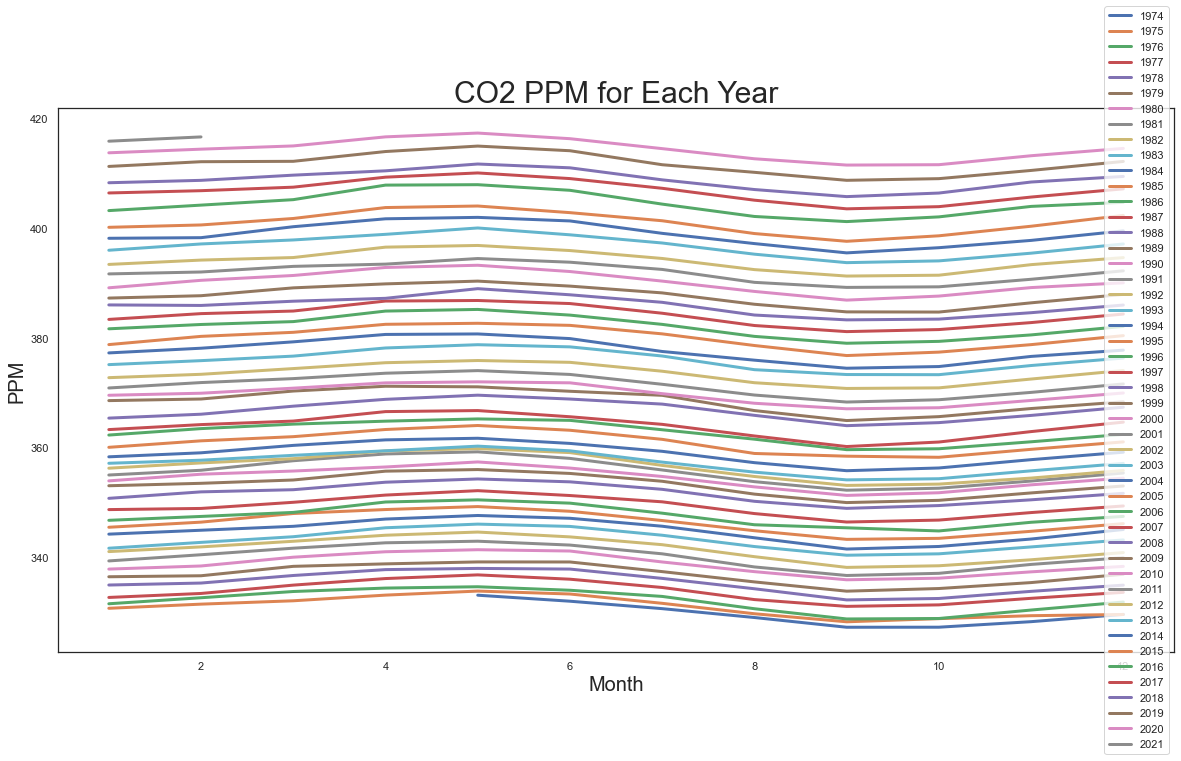

In [8]:
#Graph the average column to confirm outliers hav e been addressed
season = weekly
season['Date'] = weekly.Date
season['year'] = weekly['Date'].dt.year
season['month'] = weekly['Date'].dt.month
spivot = pd.pivot_table(season, index='month', columns = 'year', values = 'average', aggfunc=np.mean)
spivot.plot(figsize=(20,10), linewidth=3)
plt.legend(loc = 'right')
plt.title('CO2 PPM for Each Year', fontsize = 30)
plt.ylabel('PPM', fontsize = 20) 
plt.xlabel('Month', fontsize = 20)
plt.show()

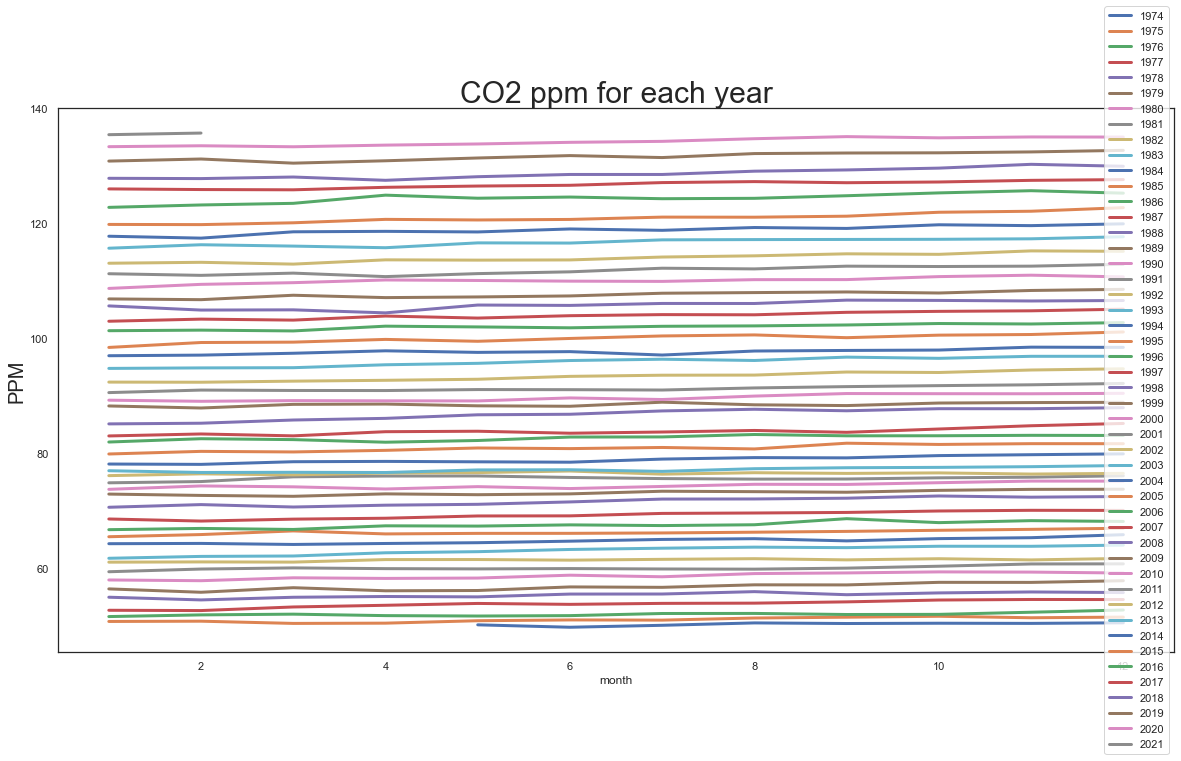

In [9]:
season = weekly
season['Date'] = weekly.Date
season['year'] = weekly['Date'].dt.year
season['month'] = weekly['Date'].dt.month
spivot = pd.pivot_table(season, index='month', columns = 'year', values = 'increase since 1800', aggfunc=np.mean)
spivot.plot(figsize=(20,10), linewidth=3)
plt.legend(loc = 'right')
plt.title('CO2 ppm for each year', fontsize = 30)
plt.ylabel('PPM', fontsize = 20)
plt.show()

In [10]:
0 % 8

0

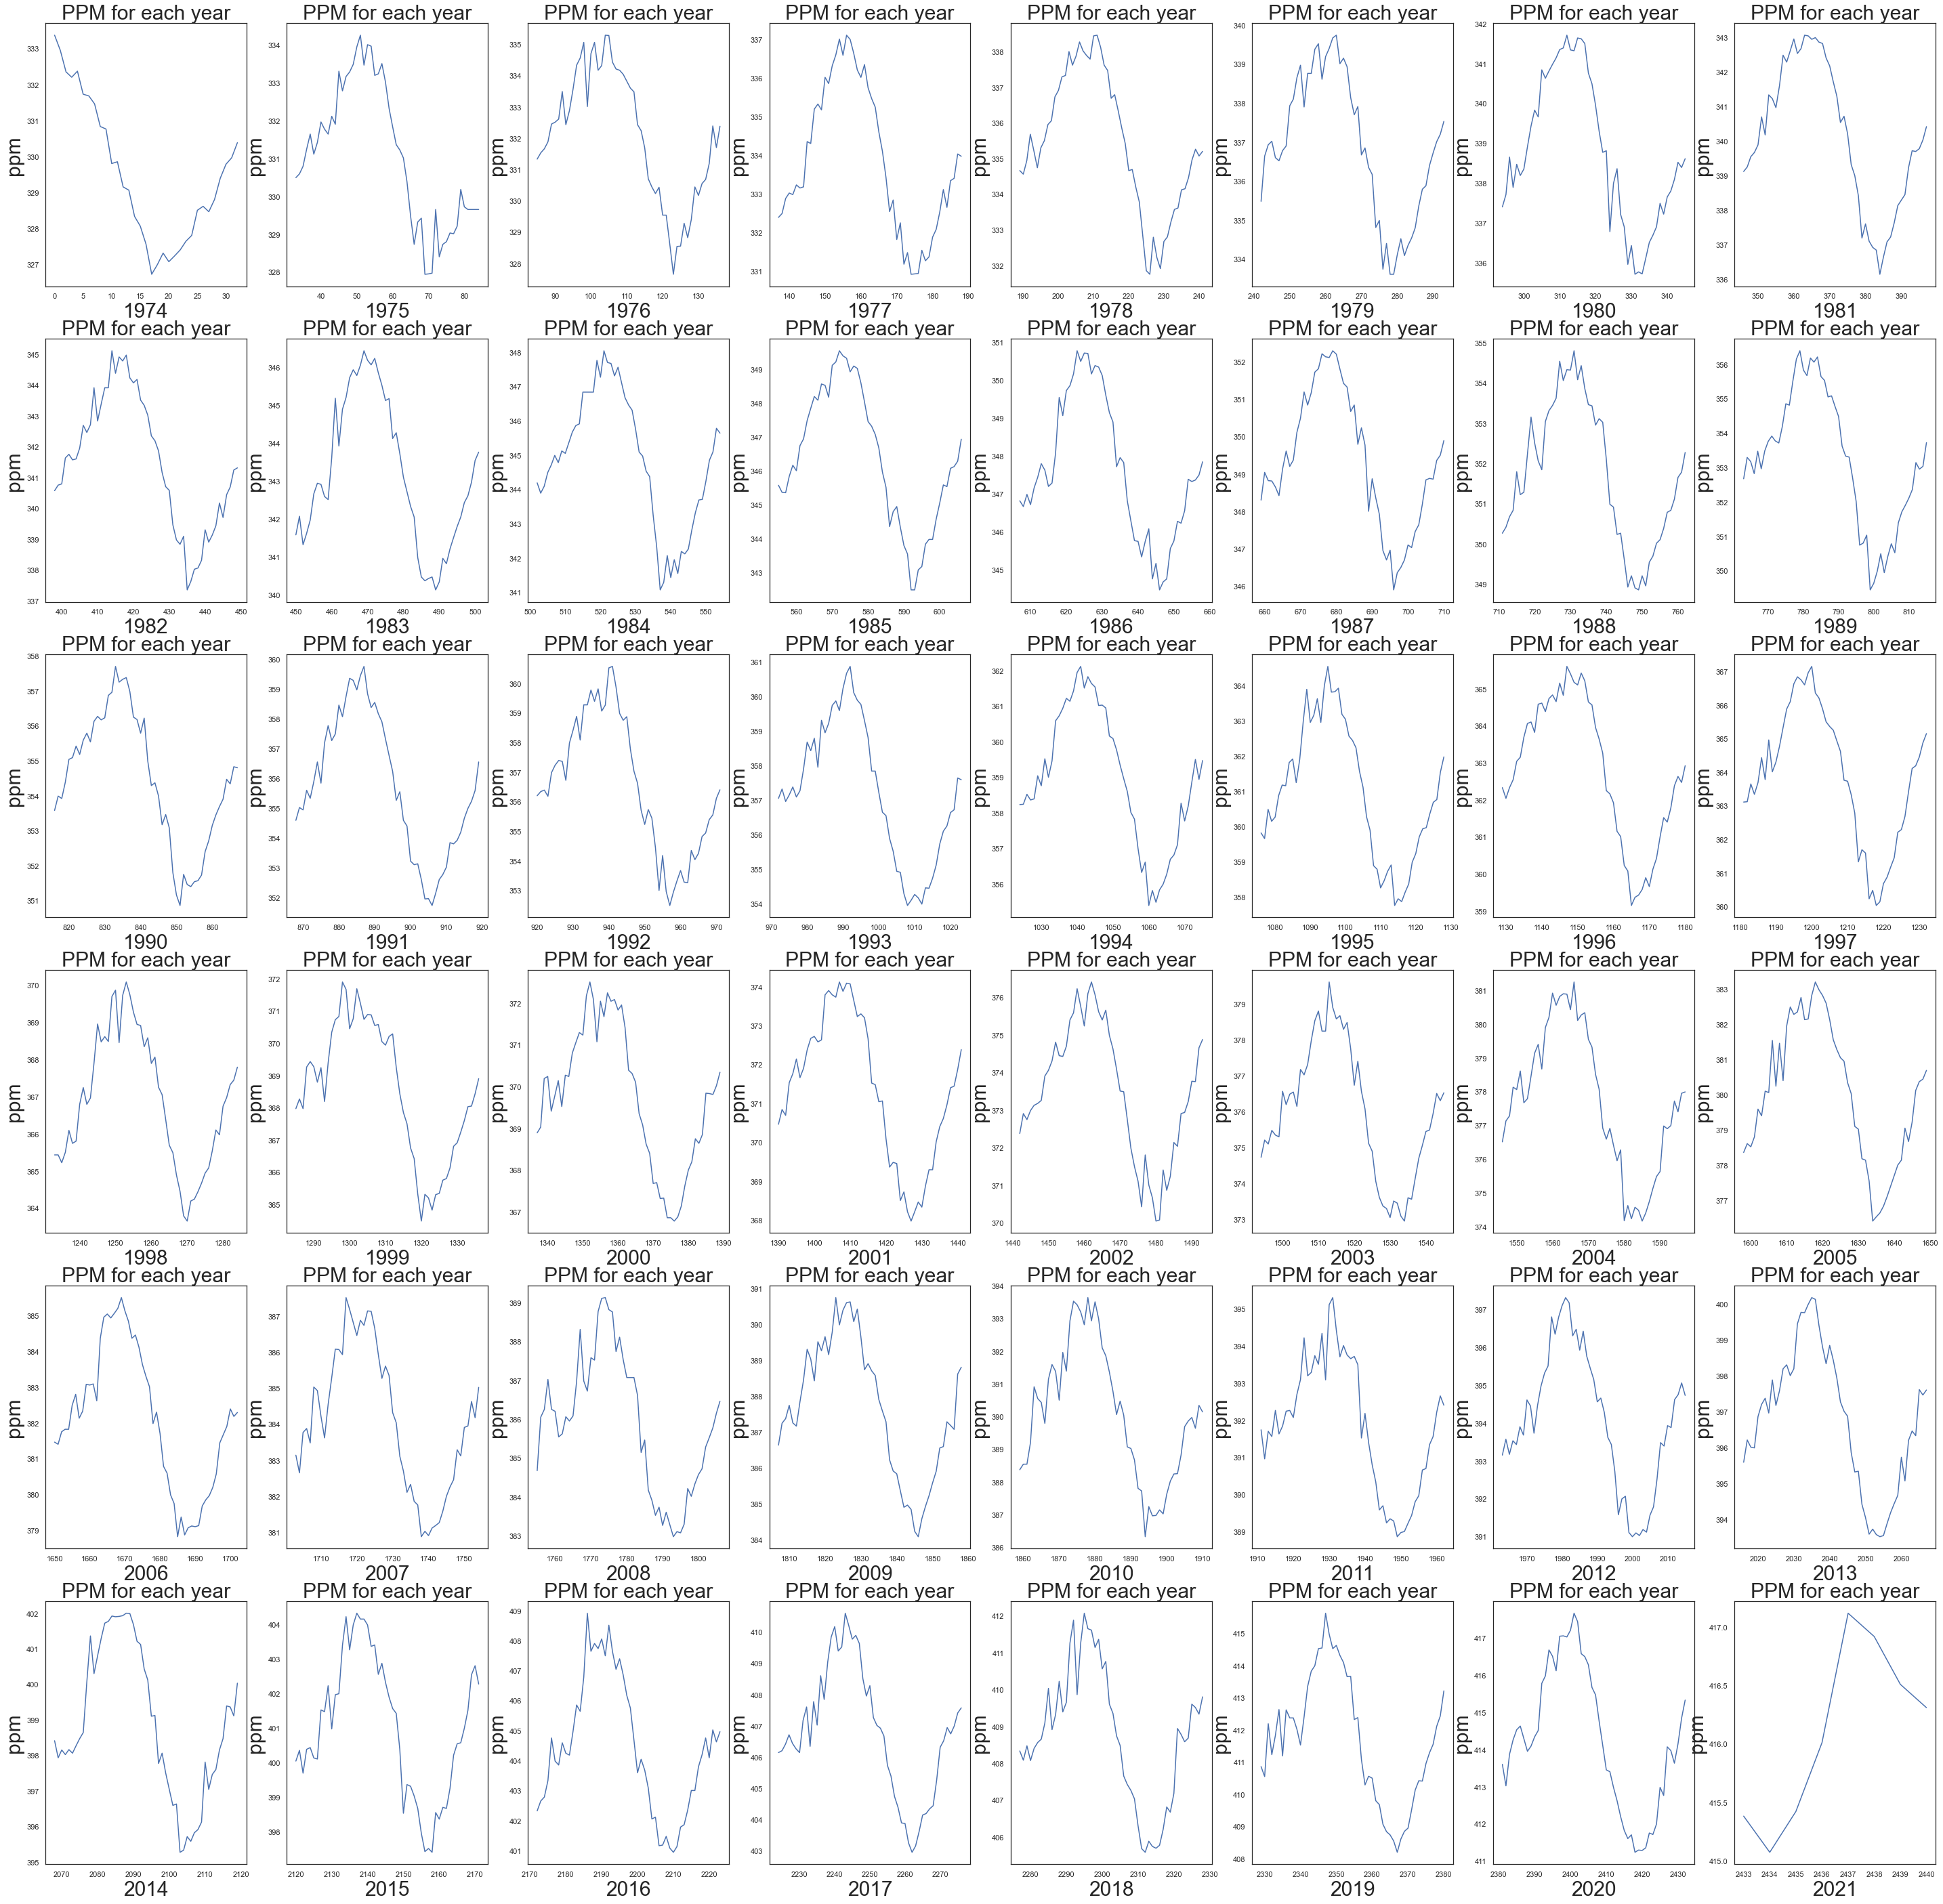

In [11]:
years = weekly['year'].unique()

fig, ax = plt.subplots(nrows = 6, ncols = 8, figsize = (50,50))

for index, year in enumerate(years):
    i = index // 8 
    j = index % 8
    current_ax = ax[i][j]
    weekly.loc[weekly['year']  == year, 'average'].plot(ax = current_ax)
    current_ax.set_title('PPM for each year', fontsize = 30)
    current_ax.set_xlabel(year, fontsize = 30)
    current_ax.set_ylabel('ppm', fontsize = 30)

In [12]:
# using groupby function with aggregation 
# to get mean, min and max values 
result = weekly.groupby('month').agg({'average': ['mean', 'min', 'max']}) 
print("Mean, min, and max values of Top Speed grouped by Vehicle Type") 
print(result)

Mean, min, and max values of Top Speed grouped by Vehicle Type
          average                
             mean     min     max
month                            
1      368.633990  330.49  417.12
2      368.984868  331.11  416.92
3      369.526863  331.64  415.98
4      370.655127  332.78  417.05
5      370.649757  332.95  417.67
6      369.430594  331.68  416.58
7      367.978846  329.80  415.47
8      365.720361  328.33  413.40
9      364.529950  326.72  411.70
10     364.534589  327.07  411.75
11     366.223218  327.80  414.07
12     367.647933  328.80  415.33


In [13]:
top_month_avg = weekly.groupby(['year', 'month', 'average']).max()
top_month_avg

day  ndays  increase since 1800       Date
year month average                                            
1974 5     332.95    26      6                50.06 1974-05-26
           333.37    19      5                50.40 1974-05-19
     6     331.68    30      6                50.02 1974-06-30
           331.73    23      5                49.72 1974-06-23
           332.20     9      7                49.65 1974-06-09
...                 ...    ...                  ...        ...
2021 1     416.01    24      7               135.50 2021-01-24
           417.12    31      7               136.49 2021-01-31
     2     416.31    21      7               135.36 2021-02-21
           416.51    14      7               135.67 2021-02-14
           416.92     7      7               136.18 2021-02-07

[2412 rows x 4 columns]

In [14]:
month_high = weekly.loc[weekly.groupby("year")["average"].idxmax()]
month_high

,year,month,day,average,ndays,increase since 1800,Date
0,1974,5,19,333.37,5,50.40,1974-05-19
51,1975,5,11,334.25,6,51.24,1975-05-11
104,1976,5,16,335.29,4,52.29,1976-05-16
156,1977,5,15,337.10,4,54.13,1977-05-15
211,1978,6,4,338.46,2,55.76,1978-06-04
263,1979,6,3,339.74,6,56.98,1979-06-03
312,1980,5,11,341.71,6,58.59,1980-05-11
363,1981,5,3,343.07,6,59.99,1981-05-03
414,1982,4,25,345.11,3,62.14,1982-04-25
469,1983,5,15,346.43,7,63.21,1983-05-15


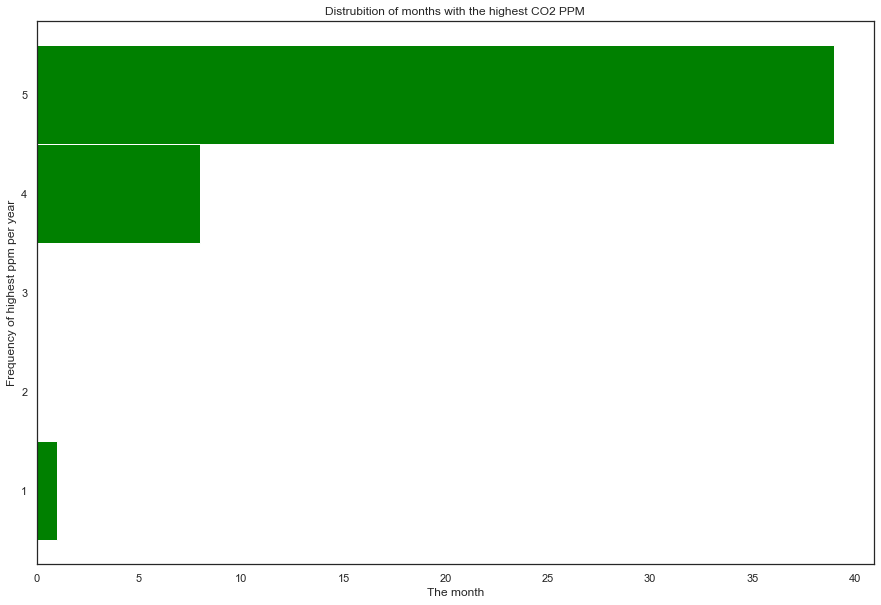

In [15]:
fig = plt.figure(figsize = (15, 10))
plt.hist(month_high.month, bins = 5, align = 'left', orientation='horizontal', color='green')
plt.title('Distrubition of months with the highest CO2 PPM')
plt.xlabel('The month')
plt.ylabel('Frequency of highest ppm per year')
plt.show();

In [16]:
weekly

,year,month,day,average,ndays,increase since 1800,Date
0,1974,5,19,333.37,5,50.40,1974-05-19
1,1974,5,26,332.95,6,50.06,1974-05-26
2,1974,6,2,332.35,5,49.60,1974-06-02
3,1974,6,9,332.20,7,49.65,1974-06-09
4,1974,6,16,332.37,7,50.06,1974-06-16
...,...,...,...,...,...,...,...
2436,2021,1,24,416.01,7,135.50,2021-01-24
2437,2021,1,31,417.12,7,136.49,2021-01-31
2438,2021,2,7,416.92,7,136.18,2021-02-07
2439,2021,2,14,416.51,7,135.67,2021-02-14


> In the northern fall, winter, and early spring, plants and soils give off CO2, causing levels to rise through May. The continued increase in CO2 and the seasonal cycle are the main features of what is known as the Keeling Curve. (https://scitechdaily.com/may-2020-had-the-highest-monthly-atmospheric-co2-reading-ever-recorded/#:~:text=In%20the%20northern%20fall%2C%20winter,vary%20by%20a%20small%20degree.)

In [17]:
upper = 400
lower = 360

supper = np.ma.masked_where(weekly.average < upper, weekly.average)
slower = np.ma.masked_where(weekly.average > lower, weekly.average)
smiddle = np.ma.masked_where((weekly.average < lower) | (weekly.average > upper) , weekly.average)

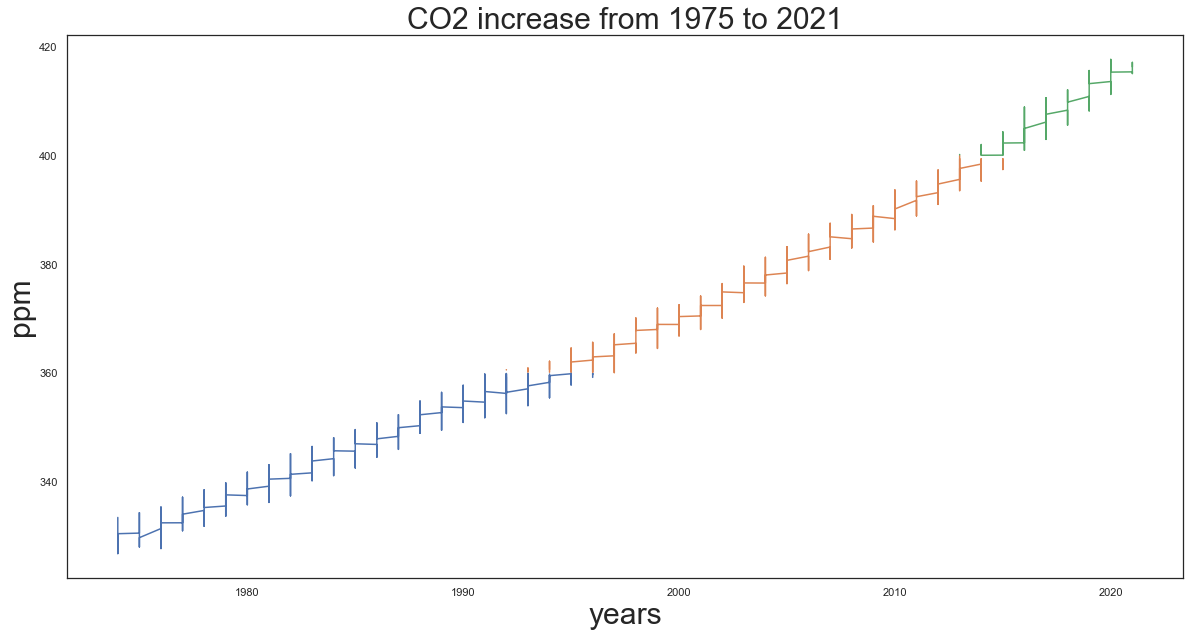

In [18]:

fig, ax= plt.subplots(figsize = (20,10))
ax.plot(weekly.year, slower, weekly.year, smiddle, weekly.year, supper);
ax.set_xlabel('years', fontsize = 30)
ax.set_ylabel('ppm', fontsize = 30)
ax.set_title('CO2 increase from 1975 to 2021', fontsize = 30)
plt.show()

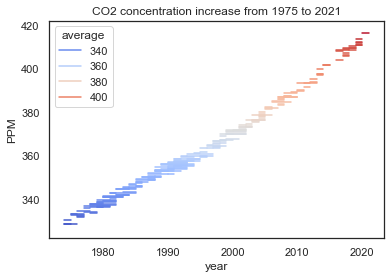

In [41]:
sns.lineplot(x = 'year', y = 'average', data = weekly, hue = 'average', palette='coolwarm')
plt.ylabel('PPM')
plt.title('CO2 concentration increase from 1975 to 2021');

In [19]:
avg_weekly = weekly.copy()
avg_weekly = avg_weekly.drop(columns = ['year', 'month', 'day', 'ndays'])

In [20]:
avg_weekly.set_index('Date', inplace = True)

In [122]:
avg_week = avg_weekly.copy()
inc_week = avg_weekly.copy()

In [123]:
avg_week = avg_week.drop(columns = ['increase since 1800'])
inc_week = inc_week.drop(columns = ['average'])

In [23]:
month_mean = avg_weekly['average'].resample('M').mean()
month_std = avg_weekly['increase since 1800'].resample('M').std()

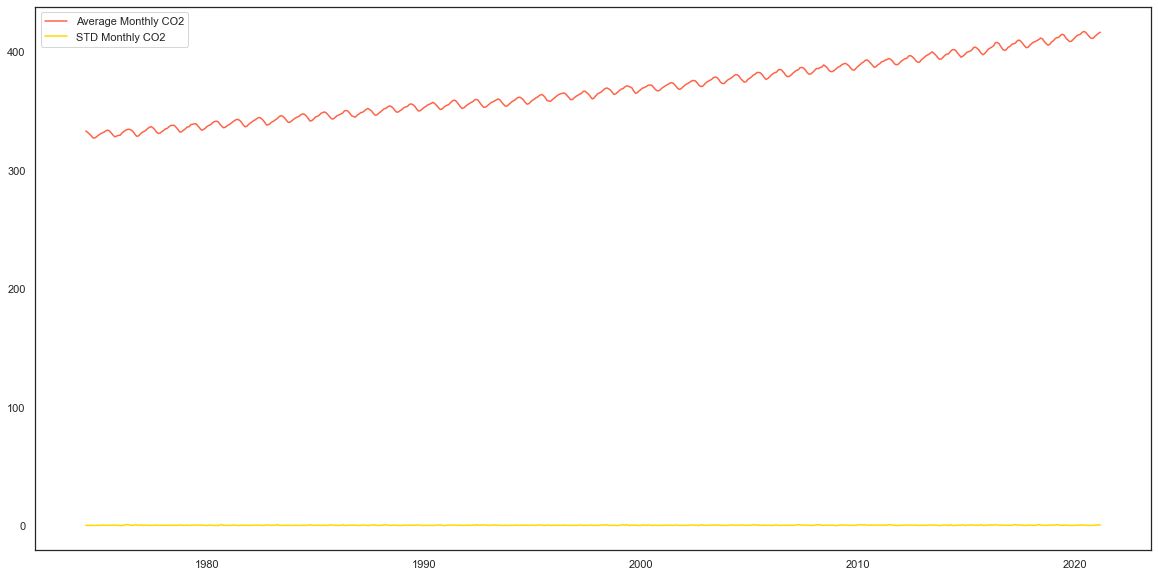

In [24]:
fig = plt.figure(figsize = (20,10))
plt.plot(month_mean, color = 'tomato', label = 'Average Monthly CO2')
plt.plot(month_std, color = 'gold', label = 'STD Monthly CO2')
plt.legend(loc = 'best')
plt.show()

<AxesSubplot:xlabel='Date'>

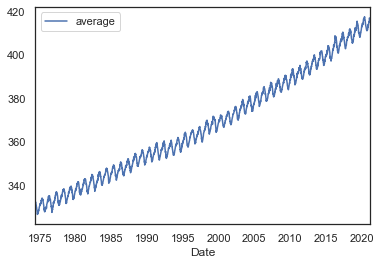

In [282]:
avg_week.plot()

In [25]:
from statsmodels.tsa.stattools import adfuller
test = adfuller(avg_weekly['average'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                    0.294789
p-value                           0.977104
#Lags Used                       27.000000
Number of Observations Used    2411.000000
dtype: float64


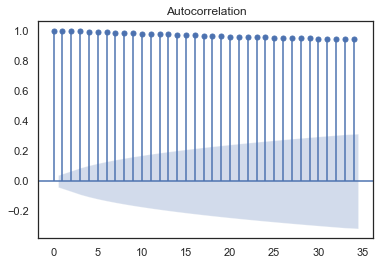

In [26]:
plot_acf(avg_weekly['average'][:-1], alpha=0.05);

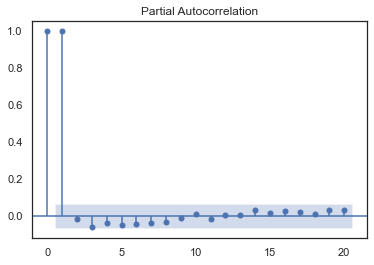

In [27]:
plot_pacf(avg_weekly['average'][:-1], alpha = 0.001, lags=20);

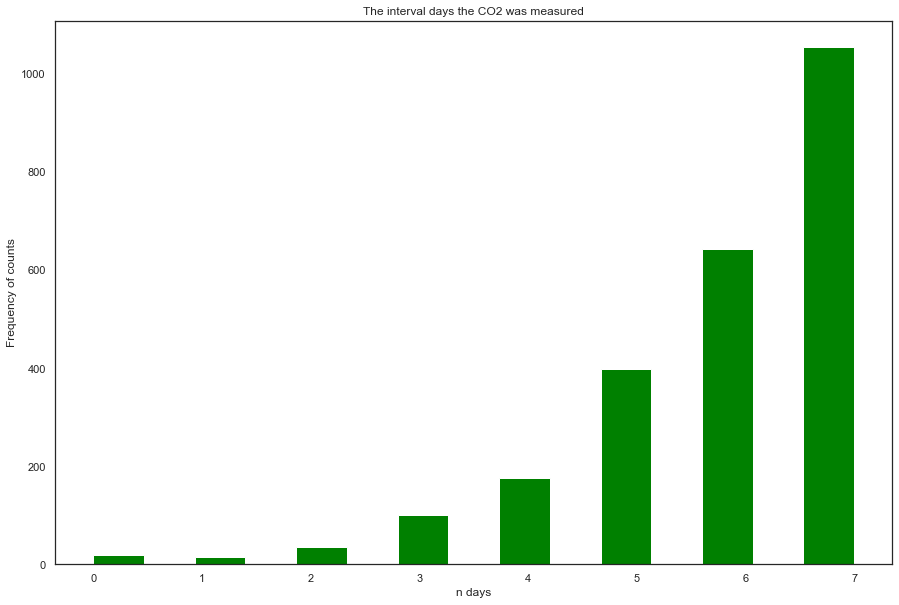

In [28]:
fig, plt.figure(figsize = (15,10))
plt.hist(weekly.ndays, bins = 15, align='mid', color = 'green')
plt.xlabel('n days')
plt.ylabel('Frequency of counts')
plt.title('The interval days the CO2 was measured')
plt.show()

In [55]:
def difference(df, interval = 7):
    diff = []
    for i in range(interval, len(df)):
        value = dataset[i] - dataset[i - interval]  
        diff.append(value)
        return Series(diff)

In [44]:
diff = weekly.average.diff()

In [197]:
diff_df = pd.DataFrame(diff)


In [198]:
diff_df = diff_df.rename(columns = {'average': 'difference'})
diff_df = diff_df.reset_index()
diff_df.dropna(inplace=True)

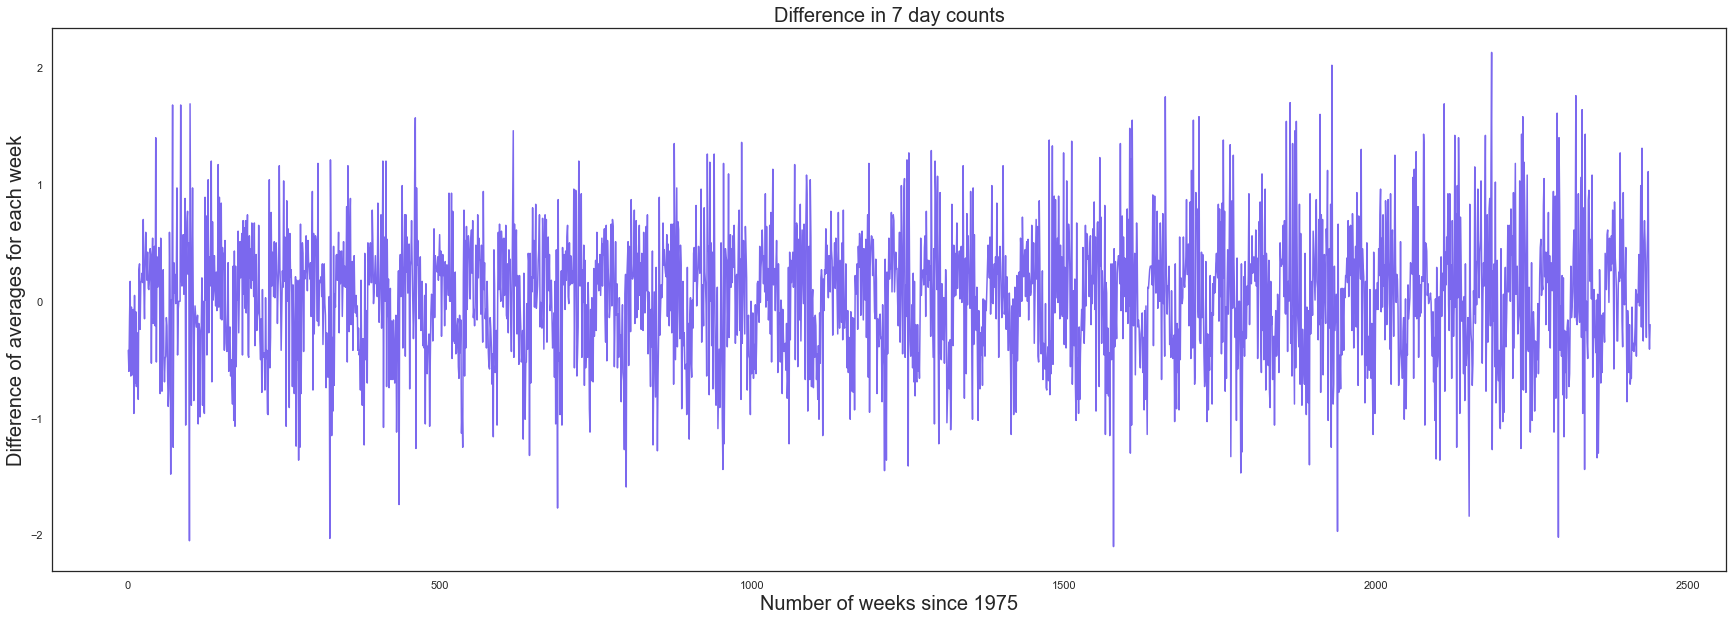

In [199]:
fig, plt.figure(figsize = (30,10))
sns.lineplot(x = 'index', y = 'difference', data = diff_df, color='mediumslateblue')
plt.xlabel('Number of weeks since 1975', fontsize = 20)
plt.title('Difference in 7 day counts', fontsize = 20)
plt.ylabel('Difference of averages for each week', fontsize = 20)
plt.show()

In [126]:
def stats_check(df, winsiz, column):
    
    
    roll_mean = df.rolling(window = winsiz, center = False).mean()
    roll_std = df.rolling(window = winsiz, center = False).std()
    
    
    dftest = adfuller(df[column])
    
    
    fig = plt.figure(figsize = (20,10))
    plt.plot(df, color = 'green', label = 'PPM ')
    plt.plot(roll_mean, color = 'red', label = 'roll mean')
    plt.plot(roll_std, color = 'blue', label = 'roll std')
    plt.legend(loc ='best')
    plt.title('Stationary Check')
    plt.xlabel('Years')
    plt.ylabel('PPM')
    plt.show()
    

    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

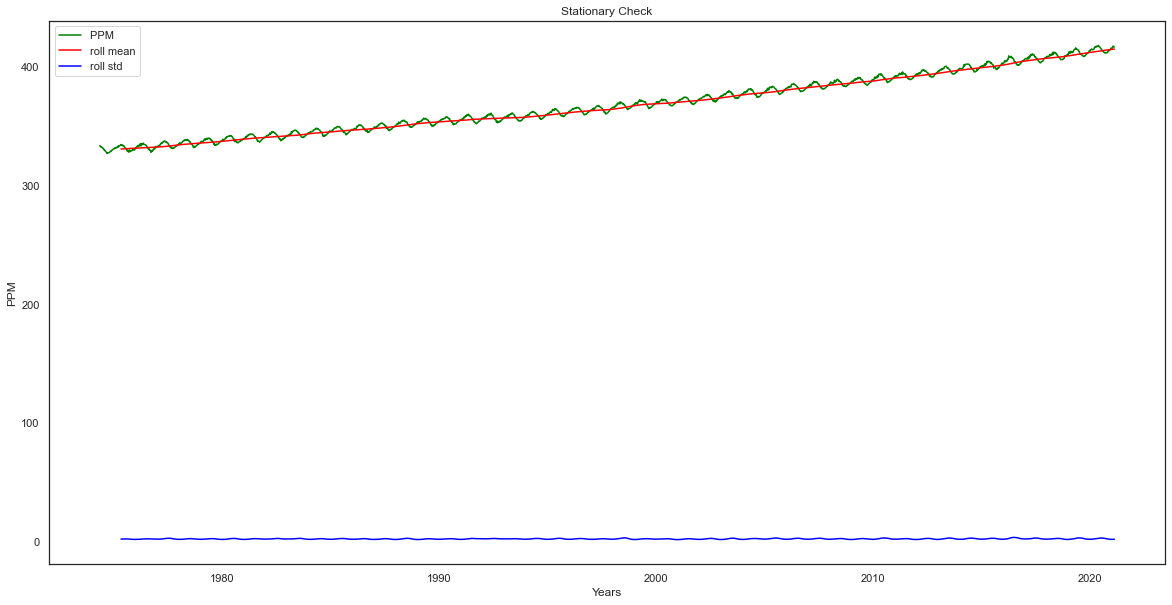

Results of Dickey-Fuller Test: 

Test Statistic                    0.265961
p-value                           0.975728
#Lags Used                       27.000000
Number of Observations Used    2413.000000
Critical Value (1%)              -3.433063
Critical Value (5%)              -2.862739
Critical Value (10%)             -2.567408
dtype: float64


In [205]:
stats_check(avg_week, 52, 'average')

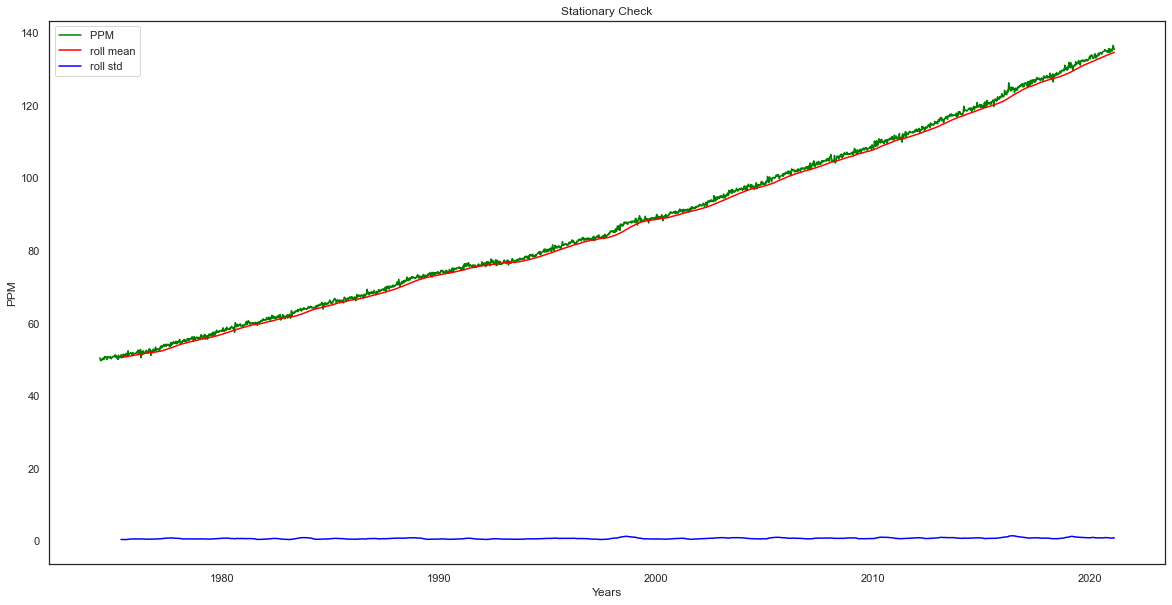

Results of Dickey-Fuller Test: 

Test Statistic                    4.289140
p-value                           1.000000
#Lags Used                       15.000000
Number of Observations Used    2425.000000
Critical Value (1%)              -3.433049
Critical Value (5%)              -2.862733
Critical Value (10%)             -2.567405
dtype: float64


In [204]:
stats_check(inc_week, 52, 'increase since 1800')

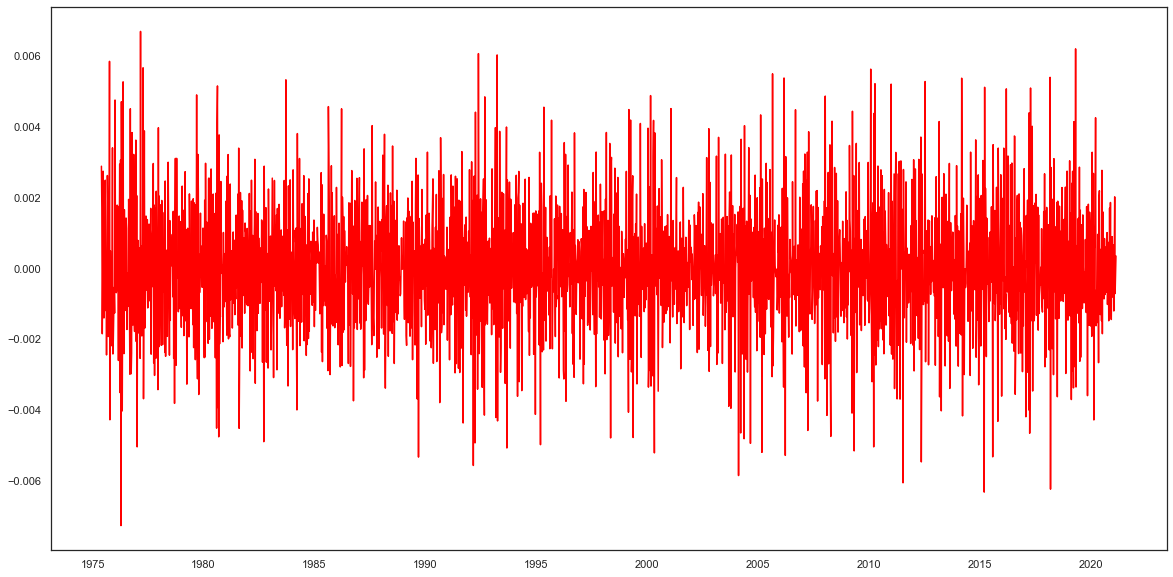

In [297]:
avg_week_log = np.log(avg_week).diff(52).diff(1)
fig = plt.figure(figsize = (20,10))
plt.plot(avg_week_log, color='red');

In [298]:
avg_week_log.dropna(inplace = True)

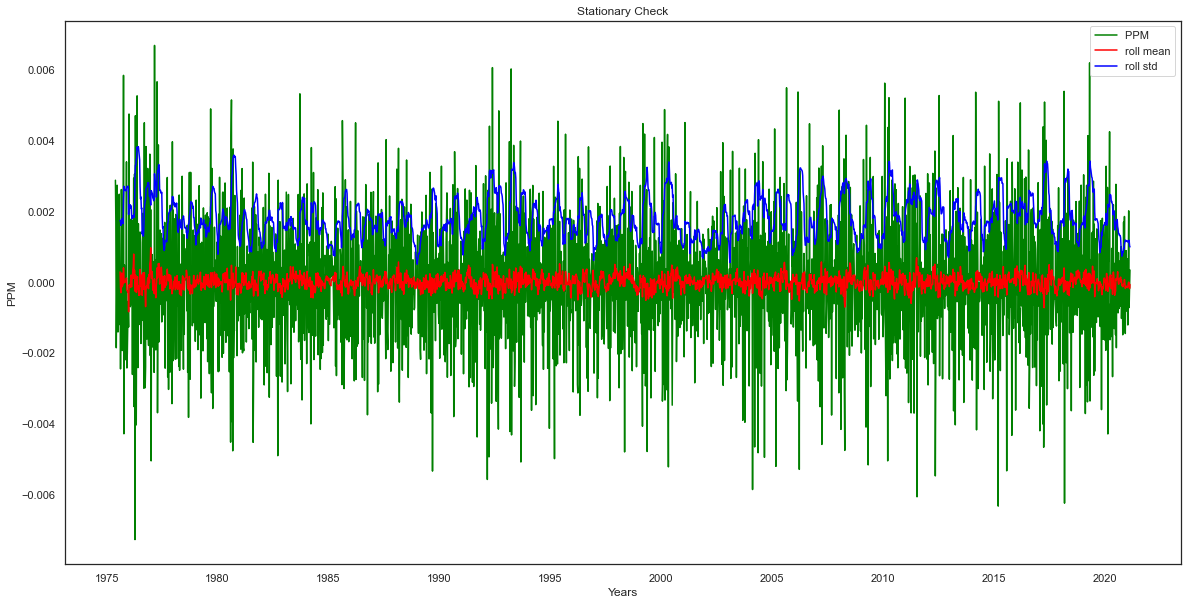

Results of Dickey-Fuller Test: 

Test Statistic                -1.846439e+01
p-value                        2.144407e-30
#Lags Used                     1.400000e+01
Number of Observations Used    2.373000e+03
Critical Value (1%)           -3.433109e+00
Critical Value (5%)           -2.862759e+00
Critical Value (10%)          -2.567419e+00
dtype: float64


In [299]:
stats_check(avg_week_log, 12, 'average')

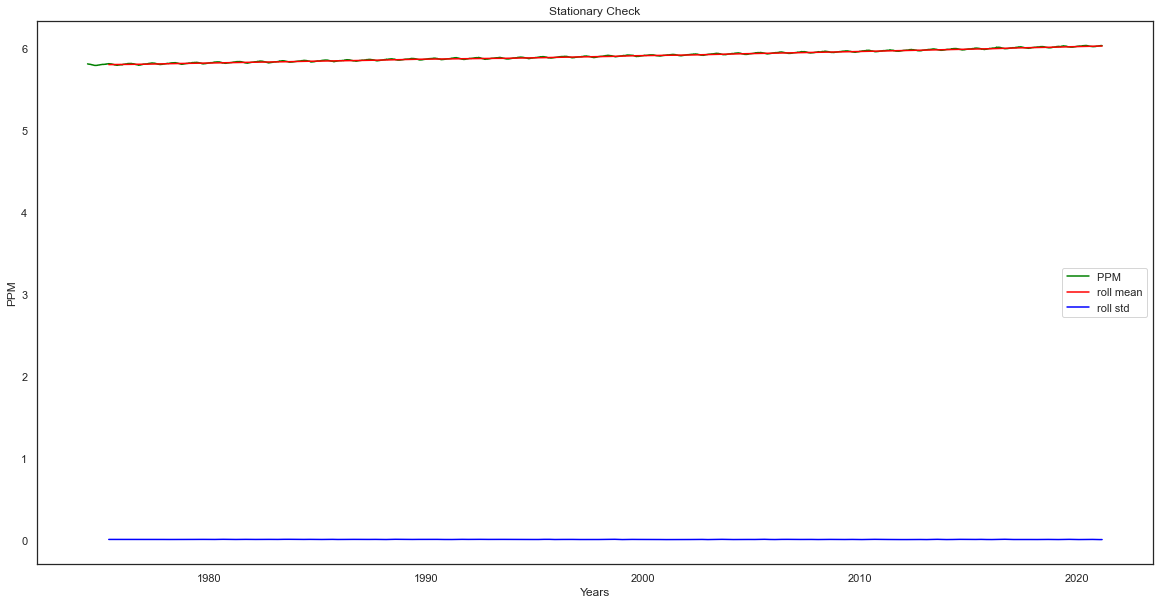

Results of Dickey-Fuller Test: 

Test Statistic                    0.006226
p-value                           0.959044
#Lags Used                       27.000000
Number of Observations Used    2413.000000
Critical Value (1%)              -3.433063
Critical Value (5%)              -2.862739
Critical Value (10%)             -2.567408
dtype: float64


In [143]:
stats_check(avg_week_log, 52, 'average')

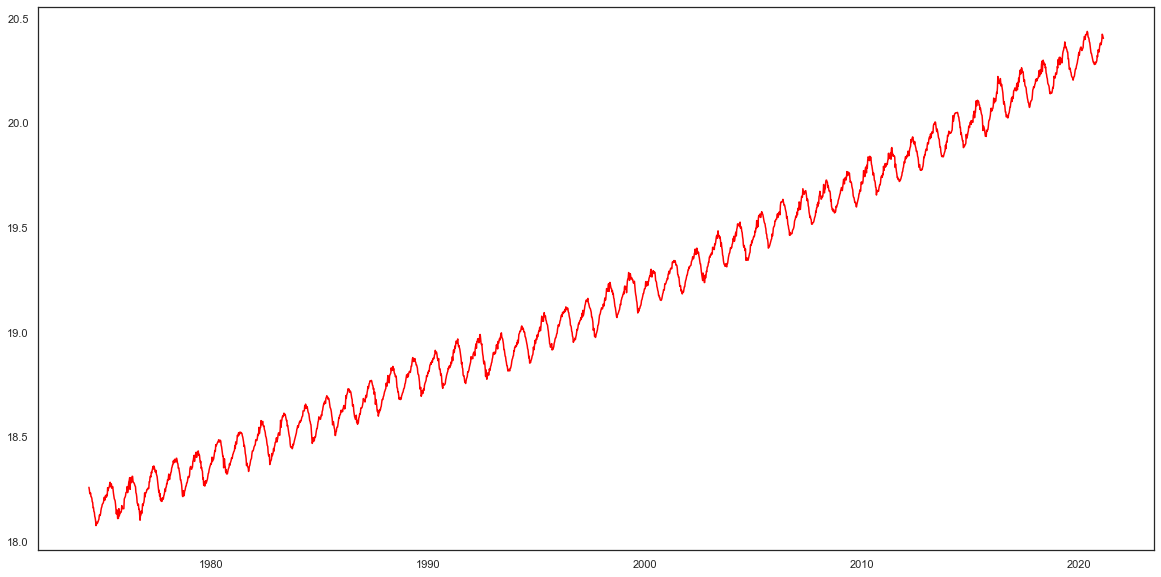

In [138]:
avg_week_sqrt = np.sqrt(avg_week)
fig = plt.figure(figsize = (20,10))
plt.plot(avg_week_sqrt, color='red');

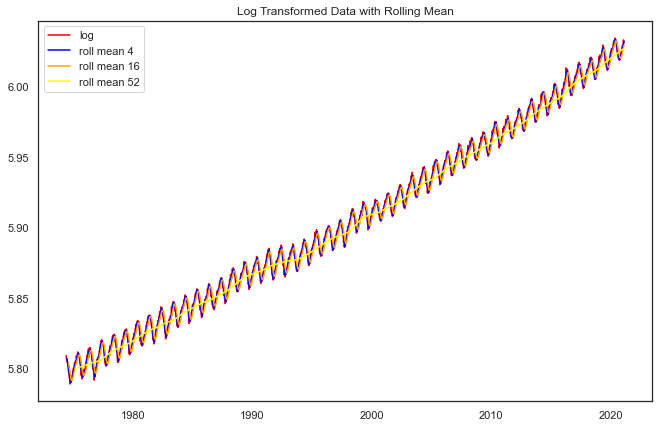

In [250]:
roll_mean_4= avg_week_log.rolling(window=4).mean()
# roll_mean_12 = avg_week_log.rolling(window=12).mean()
# roll_mean_52 = avg_week_log.rolling(window=52).mean()
fig = plt.figure(figsize=(11,7)) 
plt.plot(avg_week_log, color='red', label = 'log')
plt.plot(roll_mean_4, color = 'blue', label = 'roll mean 4')
# plt.plot(roll_mean_12, color = 'orange', label = 'roll mean 16')
# plt.plot(roll_mean_52, color = 'yellow', label = 'roll mean 52')
plt.legend(loc='best')
plt.title('Log Transformed Data with Rolling Mean')
plt.show()

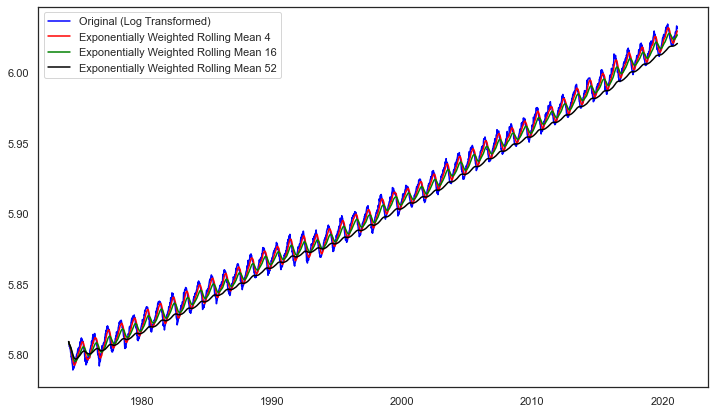

In [251]:
# Calculate Weighted Moving Average of log transformed data
exp_roll_mean_4 = avg_week_log.ewm(halflife = 4).mean()
# exp_roll_mean_12 = avg_week_log.ewm(halflife = 12).mean()
# exp_roll_mean_52 = avg_week_log.ewm(halflife = 52).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
plt.plot(avg_week_log, color='blue',label='Original (Log Transformed)')
plt.plot(exp_roll_mean_4, color='red', label='Exponentially Weighted Rolling Mean 4')
# plt.plot(exp_roll_mean_12, color='green', label='Exponentially Weighted Rolling Mean 16')
# plt.plot(exp_roll_mean_52, color='black', label='Exponentially Weighted Rolling Mean 52')
plt.legend(loc='best')
plt.show(block=False)

In [255]:
df_minus_exp_roll_mean_4 = exp_roll_mean_4 - avg_week_log
# df_minus_exp_roll_mean_12 = exp_roll_mean_12 - avg_week_log
# df_minus_exp_roll_mean_52 = exp_roll_mean_52 - avg_week_log


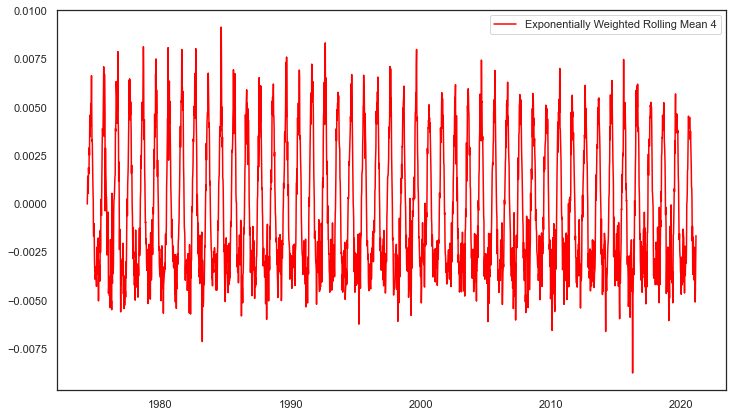

In [261]:
# Plot the time series
fig = plt.figure(figsize=(12,7))
plt.plot(df_minus_exp_roll_mean_4, color='red', label='Exponentially Weighted Rolling Mean 4')
# plt.plot(df_minus_exp_roll_mean_12, color='green', label='Exponentially Weighted Rolling Mean 12')
#plt.plot(df_minus_exp_roll_mean_52, color='blue', label='Exponentially Weighted Rolling Mean 52')
plt.legend(loc='best')
plt.show(block=False)

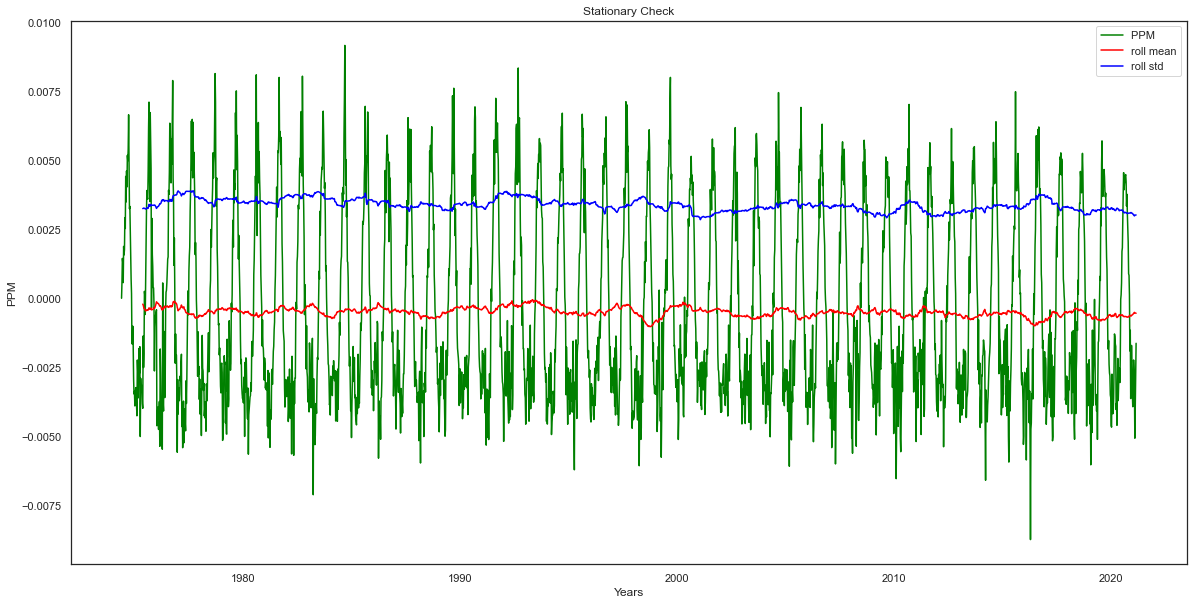

Results of Dickey-Fuller Test: 

Test Statistic                  -23.040816
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    2413.000000
Critical Value (1%)              -3.433063
Critical Value (5%)              -2.862739
Critical Value (10%)             -2.567408
dtype: float64


In [262]:
stats_check(df_minus_exp_roll_mean_4, 52, 'average')
# stats_check(df_minus_exp_roll_mean_12, 52, 'average')
# stats_check(df_minus_exp_roll_mean_52, 52, 'average')

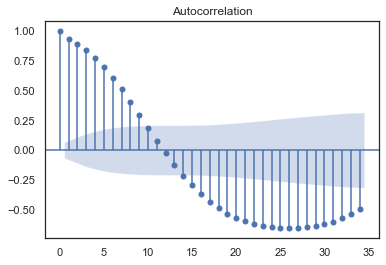

In [263]:
plot_acf(df_minus_exp_roll_mean_4.average[:-1], alpha =0.001);
# plot_acf(df_minus_exp_roll_mean_16.average[:-1], alpha =0.001);
# plot_acf(df_minus_exp_roll_mean_26.average[:-1], alpha =0.001);
# plot_acf(df_minus_exp_roll_mean_52.average[:-1], alpha =0.001);

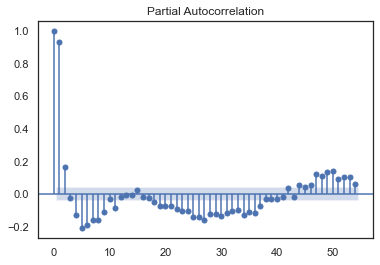

In [264]:
plot_pacf(df_minus_exp_roll_mean_4.average[:-1], alpha=0.05, lags = 54);
# plot_pacf(df_minus_exp_roll_mean_16.average[:-1], alpha=0.05, lags = 54);
# plot_pacf(df_minus_exp_roll_mean_26.average[:-1], alpha=0.05, lags = 54);
# plot_pacf(df_minus_exp_roll_mean_52.average[:-1], alpha=0.05, lags = 54);

In [271]:
diff_avg_week = df_minus_exp_roll_mean_4.diff(periods=12)
# diff_avg_week_16 = df_minus_exp_roll_mean_16.diff(periods=12)
# diff_avg_week_26 = df_minus_exp_roll_mean_26.diff(periods=12)
# diff_avg_week_52 = df_minus_exp_roll_mean_52.diff(periods=12)

In [272]:
diff_avg_week.dropna(inplace=True)
# diff_avg_week_16.dropna(inplace=True)
# diff_avg_week_26.dropna(inplace=True)
# diff_avg_week_52.dropna(inplace=True)

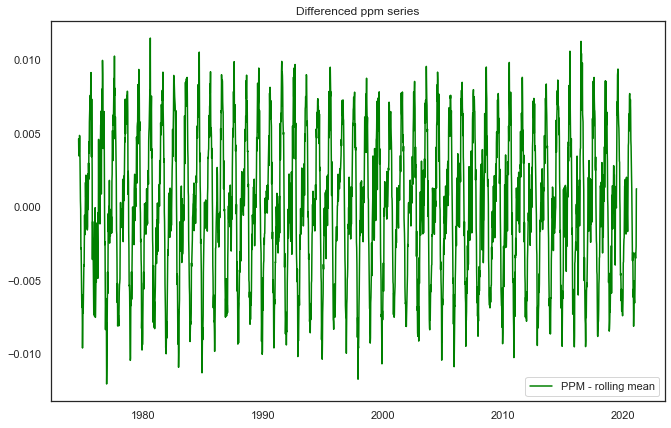

In [273]:
fig = plt.figure(figsize=(11,7))
plt.plot(diff_avg_week, color='green',label='PPM - rolling mean')
# plt.plot(diff_avg_week_16, color='red',label='PPM - rolling mean')
# plt.plot(diff_avg_week_26, color='yellow',label='PPM - rolling mean')
# plt.plot(diff_avg_week_52, color='blue',label='PPM - rolling mean')
plt.legend(loc='best')
plt.title('Differenced ppm series')
plt.show(block=False)

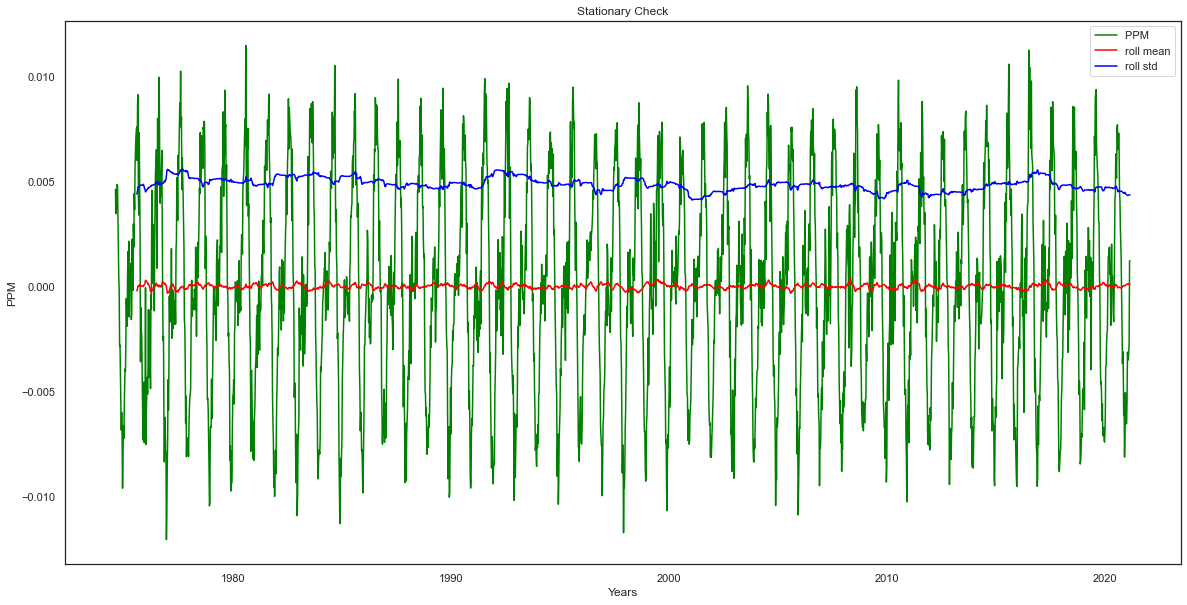

Results of Dickey-Fuller Test: 

Test Statistic                  -20.748956
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    2401.000000
Critical Value (1%)              -3.433076
Critical Value (5%)              -2.862745
Critical Value (10%)             -2.567411
dtype: float64


In [274]:
stats_check(diff_avg_week, 52, 'average');
# stats_check(diff_avg_week_16, 52, 'average');
# stats_check(diff_avg_week_26, 52, 'average');
# stats_check(diff_avg_week_52, 52, 'average');

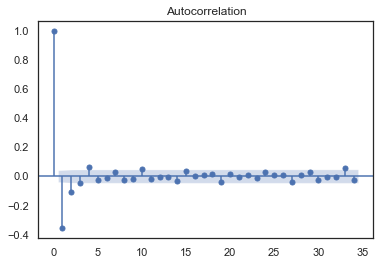

In [350]:
plot_acf(avg_week_log.average[:-1], alpha =0.05);
# plot_acf(diff_avg_week_16.average[:-1], alpha =0.001);
# plot_acf(diff_avg_week_26.average[:-1], alpha =0.001);
# plot_acf(diff_avg_week_52.average[:-1], alpha =0.001);

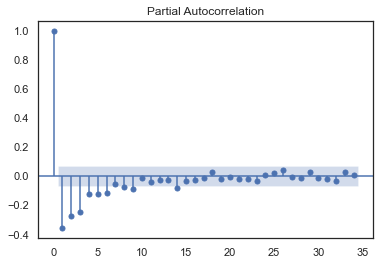

In [303]:
plot_pacf(avg_week_log.average[:-1], alpha=0.001);
# plot_pacf(diff_avg_week_16.average[:-1], alpha=0.05, lags = 30);
# plot_pacf(diff_avg_week_26.average[:-1], alpha=0.05, lags = 30);
# plot_pacf(diff_avg_week_52.average[:-1], alpha=0.05, lags = 30);

In [464]:
diff_avg_week_train_reg = avg_week.average[:round(len(avg_week_log) * 0.95)]
diff_avg_week_test_reg = avg_week.average[round(len(avg_week_log) * 0.95):]
len(diff_avg_week_test_reg)

172

In [463]:
diff_avg_week_train = avg_week_log.average[:round(len(avg_week_log) * 0.8)]
diff_avg_week_test = avg_week_log.average[round(len(avg_week_log) * 0.8):]
len(diff_avg_week_test)

478

In [475]:
avg_log_df = avg_week_log.copy()

In [481]:
avg_week.index[-172:]

DatetimeIndex(['2017-11-12', '2017-11-19', '2017-11-26', '2017-12-03',
               '2017-12-10', '2017-12-17', '2017-12-24', '2017-12-31',
               '2018-01-07', '2018-01-14',
               ...
               '2020-12-20', '2020-12-27', '2021-01-03', '2021-01-10',
               '2021-01-17', '2021-01-24', '2021-01-31', '2021-02-07',
               '2021-02-14', '2021-02-21'],
              dtype='datetime64[ns]', name='Date', length=172, freq=None)

In [477]:
avg_dat = avg_week.copy()
avg_dat.reset_index(inplace=True)

In [457]:
avg_dat = avg_dat.drop(columns =['average'])

In [465]:
avg_dat.Date[-172:]

2269   2017-11-12
2270   2017-11-19
2271   2017-11-26
2272   2017-12-03
2273   2017-12-10
          ...    
2436   2021-01-24
2437   2021-01-31
2438   2021-02-07
2439   2021-02-14
2440   2021-02-21
Name: Date, Length: 172, dtype: datetime64[ns]

In [367]:
avg_log_df.reset_index(inplace=True)

In [378]:
avg_log_df.Date[-478:]

1910   2012-01-01
1911   2012-01-08
1912   2012-01-15
1913   2012-01-22
1914   2012-01-29
          ...    
2383   2021-01-24
2384   2021-01-31
2385   2021-02-07
2386   2021-02-14
2387   2021-02-21
Name: Date, Length: 478, dtype: datetime64[ns]

# ARMA!!!!

In [391]:
mod_arma_1 = ARMA(diff_avg_week_train, (3, 1))
res_arma_1 = mod_arma_1.fit(disp=1)
res_arma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                average   No. Observations:                 1910
Model:                     ARMA(3, 1)   Log Likelihood                9653.161
Method:                       css-mle   S.D. of innovations              0.002
Date:                Wed, 10 Mar 2021   AIC                         -19294.322
Time:                        18:00:07   BIC                         -19260.992
Sample:                    05-25-1975   HQIC                        -19282.055
                         - 12-25-2011                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.136e-06   7.43e-06      0.153      0.878   -1.34e-05    1.57e-05
ar.L1.average     0.2137      0.037      5.815      0.000       0.142       0.286
ar.L2.average    -0.0513      0.029     -1.794      0.073      -0.107       0.005
ar.L3.average    -0.0214      0.029     -0.728      0.467      -0.079       0.036
ma.L1.average    -0.8198      0.029    -28.137      0.000      -0.877      -0.763
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6201           -2.3796j            2.8788           -0.1549
AR.2            1.6201           +2.3796j            2.8788            0.1549
AR.3           -5.6397           -0.0000j            5.6397           -0.5000
MA.1            1.2198           +0.0000j            1.2198            0.0000
-----------------------------------------------------------------------------
"""

In [392]:
mod_arma_2 = ARMA(diff_avg_week_train, (6, 2))
res_arma_2 = mod_arma_2.fit(disp=1)
res_arma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                average   No. Observations:                 1910
Model:                     ARMA(6, 2)   Log Likelihood                9657.291
Method:                       css-mle   S.D. of innovations              0.002
Date:                Wed, 10 Mar 2021   AIC                         -19294.582
Time:                        18:00:13   BIC                         -19239.033
Sample:                    05-25-1975   HQIC                        -19274.138
                         - 12-25-2011                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.139e-06   6.96e-06      0.164      0.870   -1.25e-05    1.48e-05
ar.L1.average    -0.3658      1.047     -0.349      0.727      -2.418       1.687
ar.L2.average     0.1327      0.266      0.499      0.617      -0.388       0.653
ar.L3.average    -0.0310      0.047     -0.664      0.507      -0.122       0.060
ar.L4.average     0.0650      0.040      1.605      0.109      -0.014       0.144
ar.L5.average     0.0397      0.081      0.491      0.624      -0.119       0.198
ar.L6.average    -0.0084      0.027     -0.315      0.753      -0.060       0.044
ma.L1.average    -0.2401      1.048     -0.229      0.819      -2.294       1.814
ma.L2.average    -0.5300      0.897     -0.591      0.555      -2.288       1.228
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.7164           -0.2017j            1.7282           -0.4814
AR.2           -1.7164           +0.2017j            1.7282            0.4814
AR.3            0.1572           -1.8732j            1.8798           -0.2367
AR.4            0.1572           +1.8732j            1.8798            0.2367
AR.5            1.8972           -0.0000j            1.8972           -0.0000
AR.6            5.9689           -0.0000j            5.9689           -0.0000
MA.1            1.1656           +0.0000j            1.1656            0.0000
MA.2           -1.6187           +0.0000j            1.6187            0.5000
-----------------------------------------------------------------------------
"""

In [393]:
res_arma_1.forecast(478)[0]
res_arma_2.forecast(478)[0]

array([-6.67911171e-04,  2.26490499e-05, -3.83329817e-05, -1.67443748e-05,
       -4.10319451e-05, -8.71527873e-06,  3.58867266e-06, -2.66757100e-06,
        4.16881880e-08, -1.20673808e-06,  2.08959346e-06,  4.46197188e-07,
        1.34798053e-06,  7.76737699e-07,  1.29818095e-06,  1.03831638e-06,
        1.18599660e-06,  1.09379158e-06,  1.15880984e-06,  1.12682490e-06,
        1.14491918e-06,  1.13409124e-06,  1.14077014e-06,  1.13760564e-06,
        1.13934607e-06,  1.13836542e-06,  1.13890556e-06,  1.13867423e-06,
        1.13879241e-06,  1.13873364e-06,  1.13875956e-06,  1.13875325e-06,
        1.13875479e-06,  1.13875540e-06,  1.13875394e-06,  1.13875561e-06,
        1.13875442e-06,  1.13875528e-06,  1.13875467e-06,  1.13875509e-06,
        1.13875483e-06,  1.13875499e-06,  1.13875489e-06,  1.13875495e-06,
        1.13875492e-06,  1.13875494e-06,  1.13875493e-06,  1.13875493e-06,
        1.13875493e-06,  1.13875493e-06,  1.13875493e-06,  1.13875493e-06,
        1.13875493e-06,  

In [394]:
print('MSE:', mean_squared_error(diff_avg_week_test, res_arma_1.forecast(478)[0]))
print('RMSE:', np.sqrt(mean_squared_error(diff_avg_week_test, res_arma_1.forecast(478)[0])))
print('MAE:', mean_absolute_error(diff_avg_week_test, res_arma_1.forecast(478)[0]))
print('AIC:', res_arma_1.aic)

MSE: 3.5934115999189164e-06
RMSE: 0.0018956296051494122
MAE: 0.0014645957744004489
AIC: -19294.321646538086


In [395]:
print('MSE:', mean_squared_error(diff_avg_week_test, res_arma_1.forecast(478)[0]))
print('RMSE:', np.sqrt(mean_squared_error(diff_avg_week_test, res_arma_1.forecast(478)[0])))
print('MAE:', mean_absolute_error(diff_avg_week_test, res_arma_1.forecast(478)[0]))
print('AIC:', res_arma_2.aic)

MSE: 3.5934115999189164e-06
RMSE: 0.0018956296051494122
MAE: 0.0014645957744004489
AIC: -19294.581515976723


In [441]:
res_arma_1.forecast(478)[0]

array([-6.86614465e-04, -1.24929783e-04,  1.21948249e-05,  2.46862839e-05,
        8.29759050e-06,  1.22065239e-06,  2.82668628e-07,  7.96231721e-07,
        1.10553666e-06,  1.16532777e-06,  1.15123537e-06,  1.13853677e-06,
        1.13526771e-06,  1.13552268e-06,  1.13601669e-06,  1.13617910e-06,
        1.13618298e-06,  1.13616491e-06,  1.13615737e-06,  1.13615660e-06,
        1.13615721e-06,  1.13615755e-06,  1.13615760e-06,  1.13615758e-06,
        1.13615757e-06,  1.13615757e-06,  1.13615757e-06,  1.13615757e-06,
        1.13615757e-06,  1.13615757e-06,  1.13615757e-06,  1.13615757e-06,
        1.13615757e-06,  1.13615757e-06,  1.13615757e-06,  1.13615757e-06,
        1.13615757e-06,  1.13615757e-06,  1.13615757e-06,  1.13615757e-06,
        1.13615757e-06,  1.13615757e-06,  1.13615757e-06,  1.13615757e-06,
        1.13615757e-06,  1.13615757e-06,  1.13615757e-06,  1.13615757e-06,
        1.13615757e-06,  1.13615757e-06,  1.13615757e-06,  1.13615757e-06,
        1.13615757e-06,  

In [396]:
exp_forecaset = np.exp(res_arma_1.forecast(478)[0])
cumsum_forecast = np.cumsum(exp_forecaset)
cumsum_forecast

array([  0.99931362,   1.9991887 ,   2.99920089,   3.99922558,
         4.99923388,   5.9992351 ,   6.99923538,   7.99923618,
         8.99923728,   9.99923845,  10.9992396 ,  11.99924074,
        12.99924187,  13.99924301,  14.99924415,  15.99924528,
        16.99924642,  17.99924755,  18.99924869,  19.99924983,
        20.99925096,  21.9992521 ,  22.99925323,  23.99925437,
        24.99925551,  25.99925664,  26.99925778,  27.99925892,
        28.99926005,  29.99926119,  30.99926232,  31.99926346,
        32.9992646 ,  33.99926573,  34.99926687,  35.999268  ,
        36.99926914,  37.99927028,  38.99927141,  39.99927255,
        40.99927369,  41.99927482,  42.99927596,  43.99927709,
        44.99927823,  45.99927937,  46.9992805 ,  47.99928164,
        48.99928277,  49.99928391,  50.99928505,  51.99928618,
        52.99928732,  53.99928846,  54.99928959,  55.99929073,
        56.99929186,  57.999293  ,  58.99929414,  59.99929527,
        60.99929641,  61.99929754,  62.99929868,  63.99

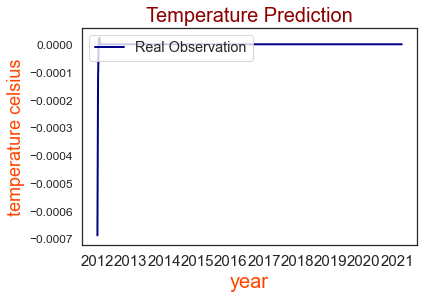

In [442]:

# avg_week_log.plot(figsize=(20,10), linewidth=2, color='firebrick')
plt.plot(avg_log_df.Date[-478:], res_arma_1.forecast(478)[0], linewidth=2, color='darkblue')
plt.xlabel('year',fontsize=20, color='orangered')
plt.ylabel('temperature celsius', fontsize=18, color='orangered')
plt.xticks(fontsize=15)
plt.yticks(fontsize=12)
plt.title('Temperature Prediction', fontsize=20, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large')

# ARIMA

In [466]:
diff_avg_week_arima_reg = ARIMA(diff_avg_week_train_reg, order=(3,1,0))
diff_avg_week_arimafit_reg = diff_avg_week_arima_reg.fit(disp=1)
diff_avg_week_arimafit_reg.forecast(172)[0]
print('MSE:', mean_squared_error(diff_avg_week_test_reg, diff_avg_week_arimafit_reg.forecast(172)[0]))
print('RMSE:', np.sqrt(mean_squared_error(diff_avg_week_test_reg, diff_avg_week_arimafit_reg.forecast(172)[0])))
print('MAE:', mean_absolute_error(diff_avg_week_test_reg, diff_avg_week_arimafit_reg.forecast(172)[0]))
print('AIC:', diff_avg_week_arimafit_reg.aic)

MSE: 23.73067458133332
RMSE: 4.871414022779558
MAE: 4.31483190016181
AIC: 3580.380362052007


In [474]:
avg_week

,average
Date,
1974-05-19,333.37
1974-05-26,332.95
1974-06-02,332.35
1974-06-09,332.20
1974-06-16,332.37
...,...
2021-01-24,416.01
2021-01-31,417.12
2021-02-07,416.92


In [467]:
diff_avg_week_arimafit_reg.forecast(172)[0]

array([404.4954385 , 404.56504522, 404.61444582, 404.65758782,
       404.70019764, 404.7371673 , 404.77288384, 404.80744331,
       404.8405648 , 404.87324476, 404.90540966, 404.93719325,
       404.96879543, 405.00021777, 405.03152831, 405.06276863,
       405.09395057, 405.12509666, 405.15621745, 405.18731947,
       405.21840946, 405.24949073, 405.2805659 , 405.31163697,
       405.34270512, 405.37377124, 405.40483598, 405.43589974,
       405.46696282, 405.49802544, 405.52908773, 405.5601498 ,
       405.59121171, 405.62227351, 405.65333523, 405.6843969 ,
       405.71545853, 405.74652014, 405.77758173, 405.80864331,
       405.83970488, 405.87076644, 405.901828  , 405.93288956,
       405.96395112, 405.99501267, 406.02607422, 406.05713578,
       406.08819733, 406.11925888, 406.15032043, 406.18138198,
       406.21244353, 406.24350508, 406.27456663, 406.30562819,
       406.33668974, 406.36775129, 406.39881284, 406.42987439,
       406.46093594, 406.49199749, 406.52305904, 406.55

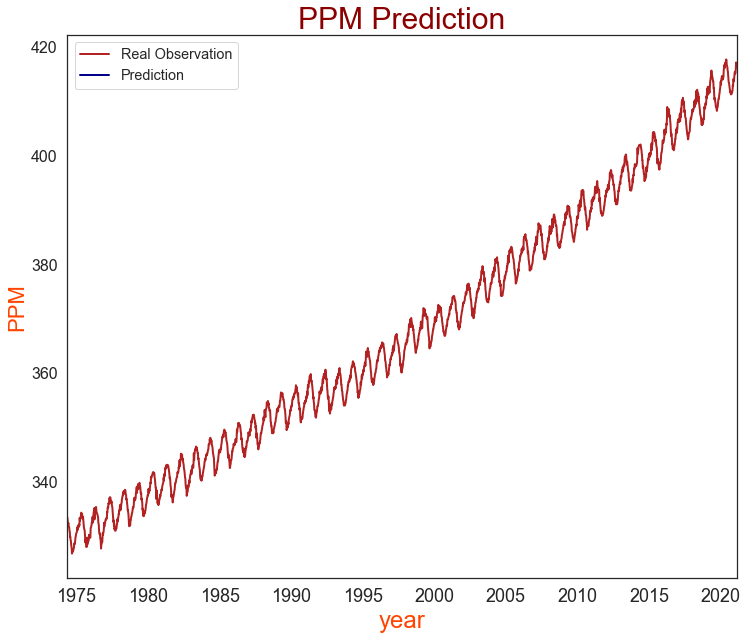

In [482]:

avg_week.plot(figsize=(12,10), linewidth=2, color='firebrick')
plt.plot(avg_week.index[-172:], diff_avg_week_arimafit_reg.forecast(172)[0], linewidth=2, color='darkblue')
plt.xlabel('year',fontsize=24, color='orangered')
plt.ylabel('PPM', fontsize=22, color='orangered')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.title('PPM Prediction', fontsize=30, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large');

In [401]:
diff_avg_week_arima = ARIMA(diff_avg_week_train, order=(3,1,0))
diff_avg_week_arimafit_1 = diff_avg_week_arima.fit(disp=1)

In [402]:
diff_avg_week_arima = ARIMA(diff_avg_week_train, order=(6,2,0))
diff_avg_week_arimafit_2 = diff_avg_week_arima.fit(disp=1)

In [419]:
diff_avg_week_arimafit_1.forecast(478)[0]
diff_avg_week_arimafit_2.forecast(478)[0]

array([0.00113889, 0.00131436, 0.00114452, 0.0004639 , 0.00102373,
       0.00101791, 0.00169437, 0.00125348, 0.00115194, 0.00138129,
       0.00164713, 0.00174439, 0.00162774, 0.00173125, 0.00179003,
       0.00202296, 0.00205782, 0.0020693 , 0.00213351, 0.00226464,
       0.0023802 , 0.00242845, 0.00249774, 0.00256532, 0.00267987,
       0.00276959, 0.00284061, 0.00290919, 0.00299791, 0.00309419,
       0.00317674, 0.00325664, 0.00333438, 0.0034235 , 0.00351275,
       0.00359789, 0.00367893, 0.00376325, 0.00385169, 0.00393902,
       0.00402491, 0.00410937, 0.00419605, 0.00428407, 0.00437203,
       0.00445874, 0.00454559, 0.00463367, 0.00472227, 0.00481082,
       0.00489896, 0.00498749, 0.00507662, 0.00516616, 0.00525564,
       0.00534514, 0.005435  , 0.00552526, 0.00561578, 0.00570637,
       0.00579714, 0.0058882 , 0.00597959, 0.00607118, 0.00616294,
       0.00625491, 0.00634715, 0.00643966, 0.00653238, 0.0066253 ,
       0.00671845, 0.00681185, 0.0069055 , 0.00699936, 0.00709

In [407]:
print('MSE:', mean_squared_error(diff_avg_week_test, diff_avg_week_arimafit_1.forecast(478)[0]))
print('RMSE:', np.sqrt(mean_squared_error(diff_avg_week_test, diff_avg_week_arimafit_1.forecast(478)[0])))
print('MAE:', mean_absolute_error(diff_avg_week_test, diff_avg_week_arimafit_1.forecast(478)[0]))
print('AIC:', diff_avg_week_arimafit_1.aic)

MSE: 3.694108022705433e-06
RMSE: 0.0019220062493929184
MAE: 0.0014981384723622045
AIC: -18283.596834789103


In [408]:
print('MSE:', mean_squared_error(diff_avg_week_test, diff_avg_week_arimafit_2.forecast(478)[0]))
print('RMSE:', np.sqrt(mean_squared_error(diff_avg_week_test, diff_avg_week_arimafit_2.forecast(478)[0])))
print('MAE:', mean_absolute_error(diff_avg_week_test, diff_avg_week_arimafit_2.forecast(478)[0]))
print('AIC:', diff_avg_week_arimafit_2.aic)

MSE: 0.001119260065857064
RMSE: 0.033455344354184485
MAE: 0.02795894919324154
AIC: -17822.598397696263


# SARIMAX

In [410]:
diff_avg_sarimax_1 = sm.tsa.statespace.SARIMAX(endog = diff_avg_week_train, order=(3,1,0))
diff_avg_sarimaxfit_1 = diff_avg_sarimax_1.fit()
diff_avg_sarimaxfit_1


In [415]:
diff_avg_sarimax_2 = sm.tsa.statespace.SARIMAX(endog = diff_avg_week_train, order=(6,2,0))
diff_avg_sarimaxfit_2 = diff_avg_sarimax_2.fit()

In [416]:
diff_avg_sarimaxfit_1.forecast(478)
diff_avg_sarimaxfit_2.forecast(478)

2012-01-01    0.001134
2012-01-08    0.001310
2012-01-15    0.001144
2012-01-22    0.000456
2012-01-29    0.001015
                ...   
2021-01-24    0.036741
2021-01-31    0.036817
2021-02-07    0.036893
2021-02-14    0.036969
2021-02-21    0.037045
Freq: W-SUN, Name: predicted_mean, Length: 478, dtype: float64

In [421]:
print('MSE:', mean_squared_error(diff_avg_week_test, diff_avg_sarimaxfit_1.forecast(478)))
print('RMSE:', np.sqrt(mean_squared_error(diff_avg_week_test, diff_avg_sarimaxfit_1.forecast(478))))
print('MAE:', mean_absolute_error(diff_avg_week_test, diff_avg_sarimaxfit_1.forecast(478)))

MSE: 3.7422949842613124e-06
RMSE: 0.0019345012236391354
MAE: 0.0015112231868105012


In [423]:
print('MSE:', mean_squared_error(diff_avg_week_test, diff_avg_sarimaxfit_2.forecast(478)))
print('RMSE:', np.sqrt(mean_squared_error(diff_avg_week_test, diff_avg_sarimaxfit_2.forecast(478))))
print('MAE:', mean_absolute_error(diff_avg_week_test, diff_avg_sarimaxfit_2.forecast(478)))


MSE: 0.000471054539174737
RMSE: 0.021703790894098133
MAE: 0.018948076587012832


In [427]:
m_auto = pm.auto_arima(diff_avg_week_train, start_p=1, start_d=1, start_q=1, max_p=10, max_d=5, max_q=10,
                             seasonal = False,
                             d=None, D=None, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-19277.930, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-18661.881, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-18911.915, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-19154.483, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-19220.844, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-19284.013, Time=0.34 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-19290.961, Time=0.44 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-19294.299, Time=0.31 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-19299.170, Time=0.37 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-19297.766, Time=0.34 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-19296.366, Time=0.72 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-19294.602, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-19289.731, Time=0.43 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-19297.271, Time=0.79 sec
 ARIM

In [428]:
m_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1910
Model:               SARIMAX(1, 0, 3)   Log Likelihood                9654.585
Date:                Wed, 10 Mar 2021   AIC                         -19299.170
Time:                        18:36:44   BIC                         -19271.396
Sample:                             0   HQIC                        -19288.948
                               - 1910                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6212      0.253     -2.457      0.014      -1.117      -0.126
ma.L1          0.0291      0.250      0.116      0.907      -0.462       0.520
ma.L2         -0.5356      0.159     -3.368      0.001      -0.847      -0.224
ma.L3         -0.1593      0.042     -3.788      0.000      -0.242      -0.077
sigma2      2.374e-06   6.75e-08     35.183      0.000    2.24e-06    2.51e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                32.90
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.03
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [430]:
weekly_auto_foca = m_auto.predict(478)

In [431]:
print('MSE:', mean_squared_error(diff_avg_week_test, weekly_auto_foca))
print('RMSE:', np.sqrt(mean_squared_error(diff_avg_week_test, weekly_auto_foca)))
print('MAE:', mean_absolute_error(diff_avg_week_test, weekly_auto_foca))

MSE: 3.590806638714919e-06
RMSE: 0.0018949423840093184
MAE: 0.0014640629402931974


In [433]:
orderlist = []
mselist = []
rmselist = []
maelist = []
for p in range(1,5):
    for d in range(1,5):
        for q in range(1,5):
            ordernow = (p,d,q)
            m_sarimax_now = sm.tsa.statespace.SARIMAX(endog = diff_avg_week_train, order=ordernow).fit()
            orderlist.append(ordernow)
            maelist.append(mean_absolute_error(diff_avg_week_test, m_sarimax_now.forecast(478)))
            rmselist.append(np.sqrt(mean_squared_error(diff_avg_week_test, m_sarimax_now.forecast(478))))
            mselist.append(mean_squared_error(diff_avg_week_test, m_sarimax_now.forecast(478)))

In [435]:
df_arimax_exo = pd.DataFrame()
df_arimax_exo['order'], df_arimax_exo['mse'], df_arimax_exo['rmse'], df_arimax_exo['mae'] = orderlist, mselist, rmselist, maelist

In [436]:
df_arimax_exo.sort_values('rmse').head()

,order,mse,rmse,mae
1,"(1, 1, 2)",0.000004,0.001893,0.001463
35,"(3, 1, 4)",0.000004,0.001894,0.001464
33,"(3, 1, 2)",0.000004,0.001894,0.001464
7,"(1, 2, 4)",0.000004,0.001895,0.001465
39,"(3, 2, 4)",0.000004,0.001896,0.001462


In [437]:
arimax_co2_best = sm.tsa.statespace.SARIMAX(endog = diff_avg_week_train, order=(1,1,2), initialization='approximate_diffuse').fit()

In [438]:
arimax_co2_best.forceast()

In [ ]:
dfy.plot(figsize=(12,10), linewidth=2, color='firebrick')
plt.plot(range(2003,2016), arimax_co2_best.forecast(steps=13, exog=co2_test), linewidth=2, color='darkblue')
plt.ylim([6.5,10])
plt.xlabel('year',fontsize=24, color='orangered')
plt.ylabel('temperature celsius', fontsize=22, color='orangered')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.title('Temperature Prediction', fontsize=30, color='darkred')
plt.legend(('Real Observation', 'Prediction'), loc='upper left', fontsize='x-large')